In [1]:
import pandas as pd
pd.options.display.max_columns = 100

In [2]:
muts_df = pd.read_pickle("./data/SER_df.pkl")
muts_df.shape

(27, 45)

In [3]:
cond_cnt_d = {"none": 0}
feat_cnt = 0
for _, mut in muts_df.iterrows():
    for feat in mut["regulators"]:
        feat_cnt += 1
        if len(feat["significantly associated conditions"]) > 0:
            for cond in feat["significantly associated conditions"]:
                if cond in cond_cnt_d.keys():                   
                    cond_cnt_d[cond] += 1
                else:
                    cond_cnt_d[cond] = 1
        else:
            cond_cnt_d["none"] += 1

cond_cnt_d

{'none': 20,
 "glycine(2mM)  L-Serine(varying concentration)  trace elements(X1)  Wolfe's vitamin solution.": 8,
 'ΔsdaA ΔsdaB ΔtdcG ΔglyA': 8,
 'glucose(2)': 2}

,condition,mutated feature count,proportion
0,none,20.0,0.666667
1,glycine(2mM) L-Serine(varying concentration) ...,8.0,0.266667
2,ΔsdaA ΔsdaB ΔtdcG ΔglyA,8.0,0.266667
3,glucose(2),2.0,0.066667


Text(0.5, 0, 'mutated feature count')

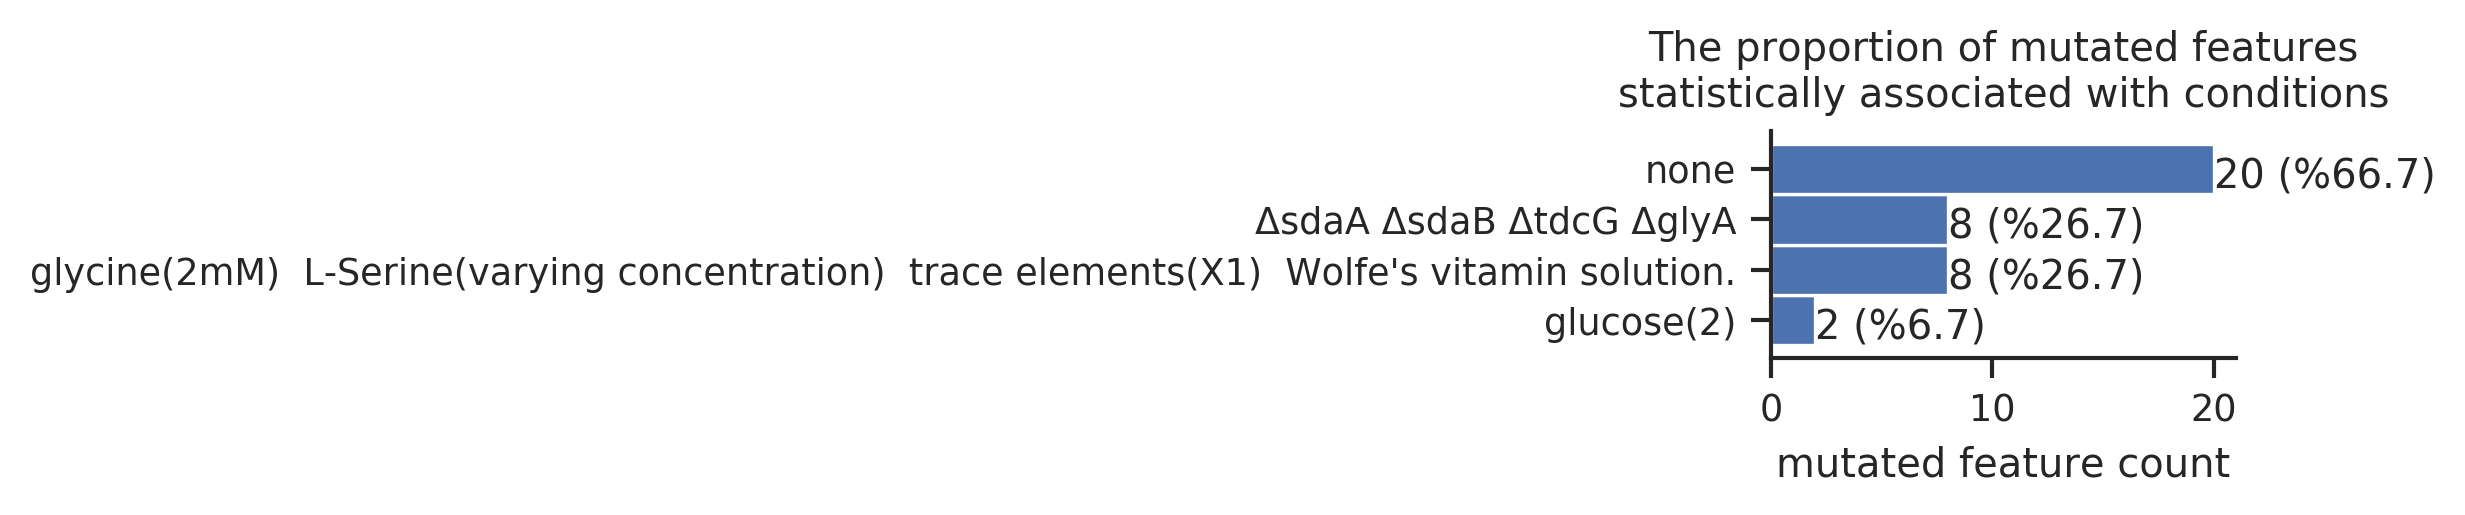

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("ticks")

cond_cnt_df = pd.DataFrame()
for key, val in cond_cnt_d.items():
    cond_cnt_df = cond_cnt_df.append({"condition": key, "mutated feature count": val, "proportion":val/feat_cnt}, ignore_index=True)
display(cond_cnt_df)

cond_cnt_df = cond_cnt_df.sort_values(by="mutated feature count", ascending=True)

ax = cond_cnt_df.plot.barh(
    y="mutated feature count",
    x="condition",
    color="#4C72B0",
    figsize=(2,1),
    width=1
)

cond_cnt_df = cond_cnt_df.reset_index()  # Resetting index for the below annotations to work
for i, r in cond_cnt_df.iterrows(): 
    s = str(int(r["mutated feature count"])) +' (%{0:.1f})'.format(r["proportion"] * 100)
    ax.text(r["mutated feature count"], i-0.35,  s)
sns.despine(ax=ax, top=True, right=True)
ax.set_title("The proportion of mutated features\nstatistically associated with conditions")
ax.get_legend().remove()
sns.despine(ax=ax, top=True, right=True)
ax.set_ylabel('')
ax.set_xlabel("mutated feature count")

In [5]:
import pickle
f = open("./data/signif_regulon_cond_json.pkl", 'rb')   
signif_genomic_feat_cond_json = pickle.load(f)
signif_genomic_feat_cond_json[0:5]

[{'mutated features': 'AcrR',
  'condition': 'glucose(2)',
  'odd ratio': 1.5194518176175962,
  'p value': 1.4348046136696324e-06},
 {'mutated features': 'AcrR',
  'condition': 'hexanoic acid',
  'odd ratio': 2.0000437225367818,
  'p value': 0.0063916141580635955},
 {'mutated features': 'AdiY',
  'condition': 'D-2-deoxyribose',
  'odd ratio': 10.04478092783505,
  'p value': 2.6702387715678554e-12},
 {'mutated features': 'AdiY',
  'condition': 'NaCl(0.5g/L) trace elements',
  'odd ratio': 2.5288788221970555,
  'p value': 0.00025128261701033933},
 {'mutated features': 'AraC',
  'condition': 'D-2-deoxyribose',
  'odd ratio': 4.377525252525253,
  'p value': 0.0032430737273837556}]

In [6]:
def get_signif_mut_conds(feat_name):
    signif_mut_conds = []
    for signif_mut_cond in signif_genomic_feat_cond_json:
        if signif_mut_cond['mutated features'] == feat_name:
            signif_mut_conds.append(signif_mut_cond)
    return signif_mut_conds
    
    

cond_mut_feat_assoc_df = pd.DataFrame()
for _, mut in muts_df.iterrows():
    for feat in mut["regulators"]:
        signif_mut_conds = get_signif_mut_conds(feat["name"])
        for d in signif_mut_conds:
            cond_mut_feat_assoc_df = cond_mut_feat_assoc_df.append(d, ignore_index=True)

cond_mut_feat_assoc_df.head()

,condition,mutated features,odd ratio,p value
0,NaCl(0.5g/L) trace elements,Cra,1.805293,6.449641e-08
1,acetate(4),Cra,5.464286,8.424633e-03
2,glucose(4),Cra,1.871608,7.580031e-04
3,glucose(4) or acetate(4),Cra,19.518797,2.060840e-14
4,glycerol(2.5),Cra,2.476350,3.645369e-03


In [7]:
SER_cond_mut_feat_assoc_df = cond_mut_feat_assoc_df[cond_mut_feat_assoc_df["condition"].isin(cond_cnt_d.keys())].copy()

cross_counts_df = pd.crosstab(
    SER_cond_mut_feat_assoc_df["mutated features"],
    SER_cond_mut_feat_assoc_df["condition"]
)

cross_counts_df

condition,glucose(2),glycine(2mM) L-Serine(varying concentration) trace elements(X1) Wolfe's vitamin solution.,ΔsdaA ΔsdaB ΔtdcG ΔglyA
mutated features,,,
GcvA,0,4,4
H-NS,2,0,0
Lrp,0,4,4


In [8]:
bin_df = cross_counts_df.copy()
for ir, r in bin_df.iterrows():
    for ic, c in r.items():
        if bin_df.loc[ir, ic] > 0:
            bin_df.loc[ir, ic] = 1
display(bin_df)

condition,glucose(2),glycine(2mM) L-Serine(varying concentration) trace elements(X1) Wolfe's vitamin solution.,ΔsdaA ΔsdaB ΔtdcG ΔglyA
mutated features,,,
GcvA,0,1,1
H-NS,1,0,0
Lrp,0,1,1


In [9]:
# only want to plot genomic targets that have significant convergences
# I only want to look at mutated targets that have significant convergence
signif_gen_targ_s = set()
for _, r in muts_df.iterrows():
    for f in r["regulators"]:
        if f["significantly enriched"]:
            signif_gen_targ_s.add(f["name"])
signif_gen_targ_s

{'GcvA'}

In [10]:
odds_df = bin_df.copy()
for ir, r in bin_df.iterrows():
    for ic, c in r.items():
        if bin_df.loc[ir, ic] > 0:
            odd_ratio = 0
            df = cond_mut_feat_assoc_df[
                (cond_mut_feat_assoc_df["condition"]==ic)
                & (cond_mut_feat_assoc_df["mutated features"]==ir)]["odd ratio"]
            if len(df):
                odd_ratio = df.iloc[0]
            odds_df.loc[ir, ic] = odd_ratio
            
odds_df = odds_df[odds_df.index.isin(signif_gen_targ_s)]
odds_df.head()

condition,glucose(2),glycine(2mM) L-Serine(varying concentration) trace elements(X1) Wolfe's vitamin solution.,ΔsdaA ΔsdaB ΔtdcG ΔglyA
mutated features,,,
GcvA,0.0,158.017544,158.017544


In [11]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.metadata_categories_for_associations import METADATA_CATEGORIES_FOR_ASSOCIATIONS

exp_conds_df = muts_df[METADATA_CATEGORIES_FOR_ASSOCIATIONS].drop_duplicates()
exp_conds_df

,temperature,carbon-source,supplement,strain-description,taxonomy-id,base-media,nitrogen-source,phosphorous-source,sulfur-source,calcium-source
1025,37 celsius,glucose(2),glycine(2mM) L-Serine(varying concentration) ...,ΔsdaA ΔsdaB ΔtdcG ΔglyA,511145,M9,NH4Cl(1),KH2PO4(3) Na2HPO4(6.8),MgSO4(0.24),CaCl2(0.1)


In [12]:
for i in exp_conds_df.columns:
    c = exp_conds_df.at[exp_conds_df.index[0], i]
    if c not in odds_df.columns:
        odds_df[c] = 0

odds_df

condition,glucose(2),glycine(2mM) L-Serine(varying concentration) trace elements(X1) Wolfe's vitamin solution.,ΔsdaA ΔsdaB ΔtdcG ΔglyA,37 celsius,511145,M9,NH4Cl(1),KH2PO4(3) Na2HPO4(6.8),MgSO4(0.24),CaCl2(0.1)
mutated features,,,,,,,,,,
GcvA,0.0,158.017544,158.017544,0,0,0,0,0,0,0


In [13]:
odds_df.to_pickle("./data/SER_key_reg_assoc_odds.pkl")

In [14]:
# plt.rcParams["figure.dpi"] = 300
# sns.set_context("paper")
# sns.set_style("whitegrid")

# from matplotlib.colors import LinearSegmentedColormap
# myColors = ('#FFFFFF', "#4C72B0")
# cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

# g = sns.clustermap(
#     odds_df,
#     linewidths=0.1,
#     cmap="BuPu",
# #     cmap=cmap,
# #     xticklabels=False,
# #     yticklabels=False,
#     figsize=(2,4.5)
# )
# # g.cax.set_visible(False)
# # g.cax.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)
# # g.ax_row_dendrogram.set_visible(False)
# # g.ax_col_dendrogram.set_visible(False)
# ax = g.ax_heatmap
# g.fig.suptitle("Overlap of associated conditions\nwith mutated features") 
# # g.ax_heatmap.set_title(
# #     "Overlap of associated conditions\nwith mutated features",
# # #     loc='top'
# # )
# # ax.yaxis.set_ticks_position('left')
# # ax.yaxis.set_label_position("left")
# ax.set_xlabel('')

The clustermap generation code in the below cell won't execute if there is only one conditions being statistically associated to mutated features

Text(0.5, 81.49999999999984, '')

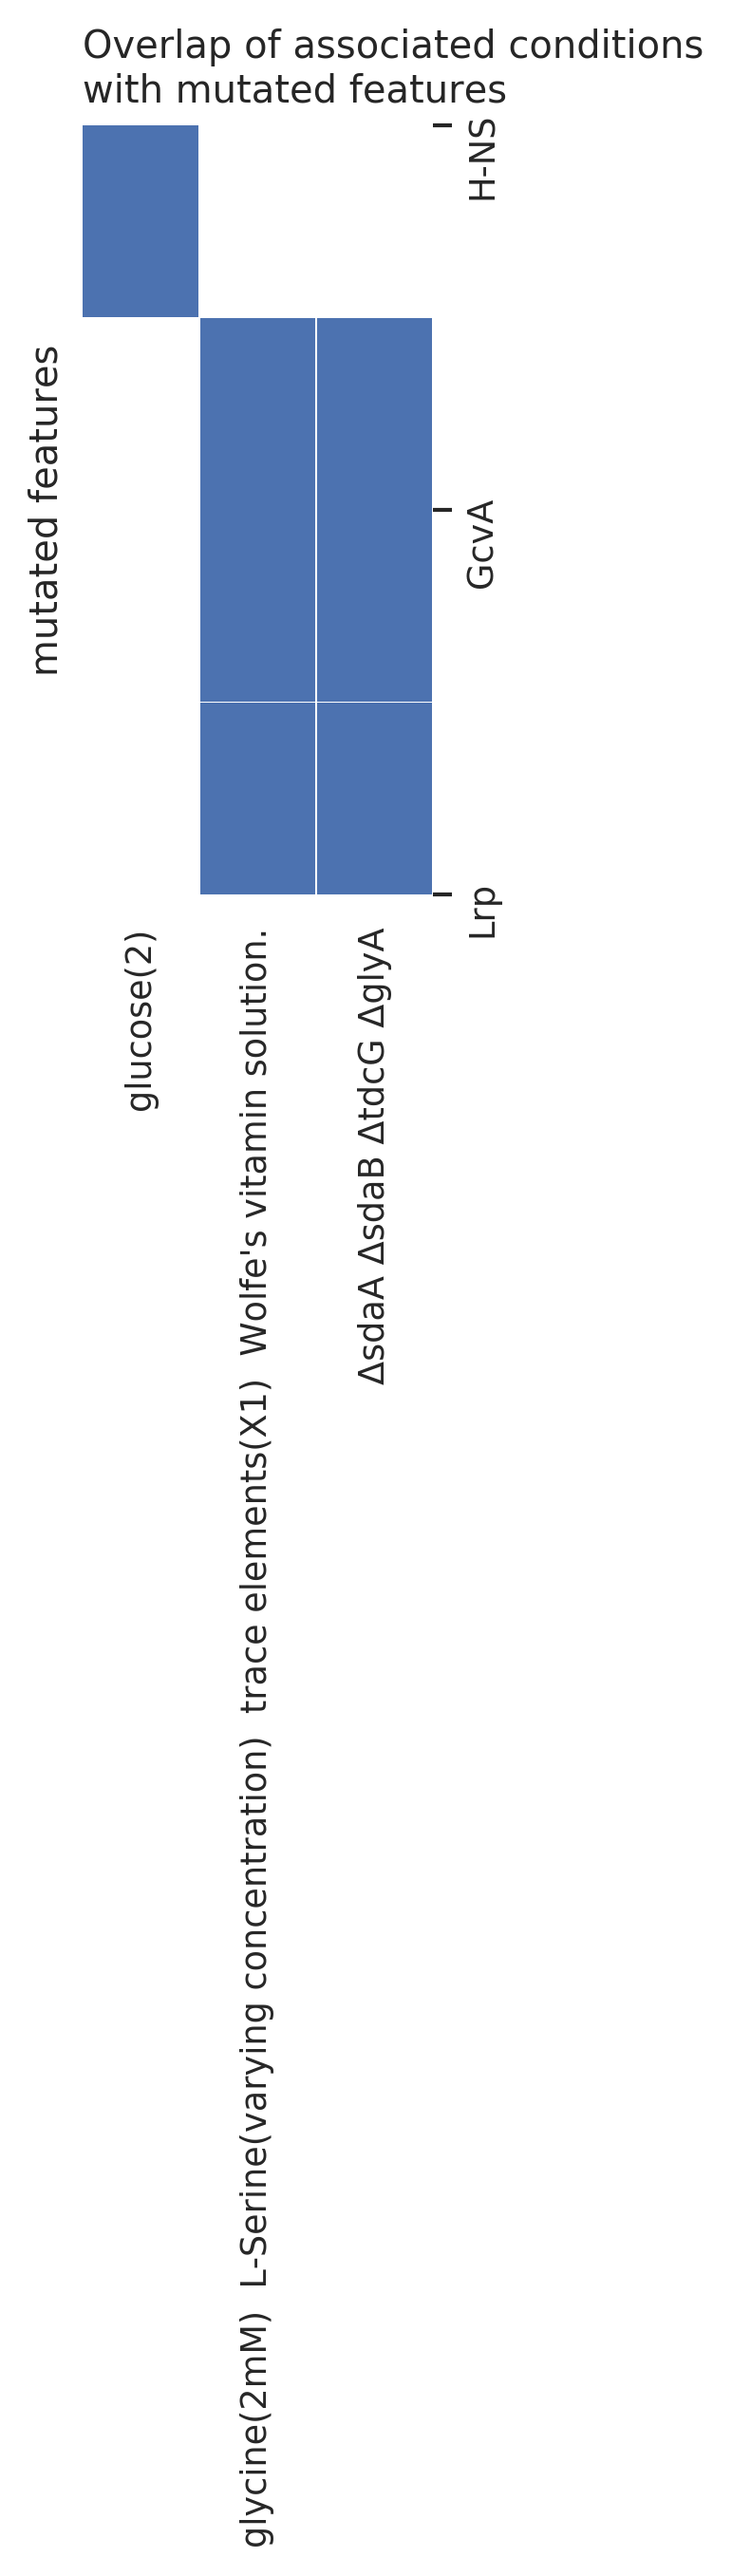

In [15]:
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("whitegrid")

from matplotlib.colors import LinearSegmentedColormap
myColors = ('#FFFFFF', "#4C72B0")
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

g = sns.clustermap(
    bin_df,
    linewidths=0.1,
    cmap=cmap,
#     xticklabels=False,
#     yticklabels=False,
    figsize=(2,4.5)
)
g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
ax = g.ax_heatmap
g.ax_heatmap.set_title(
    "Overlap of associated conditions\nwith mutated features",
    loc='left'
)
# ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_position("left")
ax.set_xlabel('')
# plt.title()

In [16]:
key_mut_feat_df = cond_mut_feat_assoc_df[
    cond_mut_feat_assoc_df["condition"].isin(cond_cnt_d.keys())
]
key_mut_feat_df = key_mut_feat_df.drop_duplicates()
key_mut_feat_df

,condition,mutated features,odd ratio,p value
24,glycine(2mM) L-Serine(varying concentration) ...,GcvA,158.017544,2.959086e-08
25,ΔsdaA ΔsdaB ΔtdcG ΔglyA,GcvA,158.017544,2.959086e-08
32,glycine(2mM) L-Serine(varying concentration) ...,Lrp,12.004057,5.841219e-04
36,ΔsdaA ΔsdaB ΔtdcG ΔglyA,Lrp,12.004057,5.841219e-04
58,glucose(2),H-NS,1.252507,2.957740e-04


In [17]:
# I only want to look at mutated targets that have significant convergence
signif_reg_s = set()
for _, r in muts_df.iterrows():
    for reg in r["regulators"]:
        if reg["significantly enriched"]:
            signif_reg_s.add(reg["name"])

key_mut_feat_df = key_mut_feat_df[key_mut_feat_df["mutated features"].isin(signif_reg_s)]

In [18]:
key_mut_feat_df

,condition,mutated features,odd ratio,p value
24,glycine(2mM) L-Serine(varying concentration) ...,GcvA,158.017544,2.959086e-08
25,ΔsdaA ΔsdaB ΔtdcG ΔglyA,GcvA,158.017544,2.959086e-08


In [19]:
# according to the above, everything associated with Serine is also associated with
# starting strain mutations with the same magnitude, therefore only looking for serine associations.
ser_key_mut_feat_df = key_mut_feat_df[key_mut_feat_df.condition=="glycine(2mM)  L-Serine(varying concentration)  trace elements(X1)  Wolfe's vitamin solution."].copy()
ser_key_mut_feat_df

,condition,mutated features,odd ratio,p value
24,glycine(2mM) L-Serine(varying concentration) ...,GcvA,158.017544,2.959086e-08


In [20]:
ser_key_mut_feat_df["mutated features"] = ser_key_mut_feat_df["mutated features"].apply(lambda s: s+" regulon")
ser_key_mut_feat_df

,condition,mutated features,odd ratio,p value
24,glycine(2mM) L-Serine(varying concentration) ...,GcvA regulon,158.017544,2.959086e-08


In [21]:
ser_key_mut_feat_df.to_pickle("./data/ser_regulon_assoc_df.pkl")

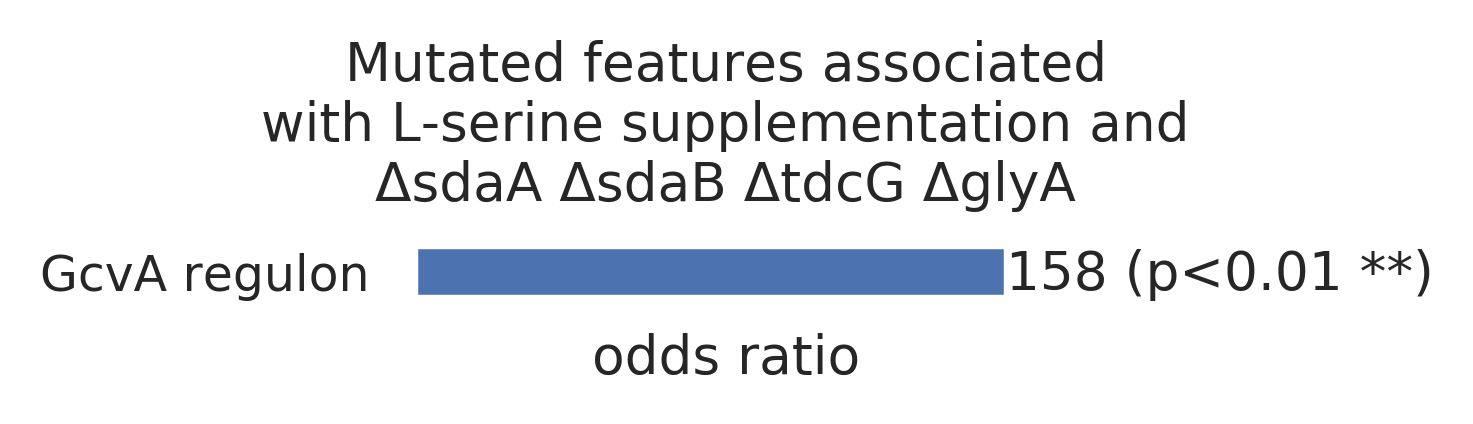

In [22]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 400
sns.set_context("paper")
sns.set_style("white")


ax = ser_key_mut_feat_df.plot.barh(
    y="odd ratio",
    x="mutated features",
    color="#4C72B0",
    figsize=(2,0.25),
    width=1
)

df = ser_key_mut_feat_df.reset_index()  # Resetting index for the below annotations to work
for i, r in df.iterrows():
    s = str(int(r["odd ratio"]))
#     ax.text(r["odd ratio"], i-0.3,  s)    
#     s = ""
    if r["p value"] < 0.01:
        s += " (p<0.01 **)"
    else:
        s += " (p=" + '{0:.3f})'.format(r["p value"])
    ax.text(r["odd ratio"], i-0.35,  s)
sns.despine(ax=ax,
            top=True,
            right=True, 
            bottom=True,
            left=True
           )
ax.set_title("Mutated features associated\nwith L-serine supplementation and\nΔsdaA ΔsdaB ΔtdcG ΔglyA")
# ax.set_title("L-serine supplementation\nand starting strain associations\nfor mutated features")
ax.get_legend().remove()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
#     bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set_ylabel('')
ax.set_xlabel("odds ratio")
plt.savefig("fig.svg", format="svg")